This notebook was created by Weilun Qin (weilun.qin@desy.de). Feb. 2024.

# Tutorial N10. Tracking with parallel-plate corrugated structures.

In this tutorial, we show a few examples for tracking with parallel-plate corrugated structures. The wakefields model we used are based on analytical wakefield formulas for flat corrugated structures. Details of the wake can be found in [Short-range wakefields in an L-shaped corrugated structure](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.26.064402). Tracking algorithm of the wakefields in OCELOT with a second order Taylor expansion method can be found in [tutorial N4. Wakefields](http://nbviewer.jupyter.org/github/ocelot-collab/ocelot/blob/master/demos/ipython_tutorials/4_wake.ipynb). Here we also present an extended 3rd order method.

## Load packages

In [1]:
# the output of plotting commands is displayed inline within frontends,
# directly below the code cell that produced it
%matplotlib inline

import sys

sys.path.append("/home/weilun/git/tmp/ocelot/")

import time

# this python library provides generic shallow (copy) and deep copy (deepcopy) operations
from copy import deepcopy

# import from Ocelot main modules and functions
from ocelot import *
from ocelot.cpbd.wake3D import *
from ocelot.adaptors.astra2ocelot import *
from ocelot.adaptors.genesis import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, to_hex

mpl.rcParams.update({'font.size':20,'axes.labelsize':20,'lines.linewidth':2}) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1f77b4','#ff7f0e','#2ca02c'])

[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.


initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation
wave.py: module PYFFTW is not installed. Install it if you want speed up dfl wavefront calculations


## Define functions

We define functions to track with different wake model for easier comparison of the models. We also add artificial tilt parameter tiltX and tiltY. In the `thin` approximation, the structure is set to 1m, but wake strength is scaled by a factor of 5. In the `thick` version, the structure length is set to 5m and scale factor is 1.

In [2]:
def track_with_tilt_thin(p_array_init, model, b, a=0.01, tiltX=0, tiltY=0):
    totalL = 1 # 1m device
    if model=='02':
        wk_tv_kick = WakeTableParallelPlate_origin(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake()
    elif model == '03':
        wk_tv_kick = WakeTableParallelPlate3_origin(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake3()
    elif model == '12':
        wk_tv_kick = WakeTableParallelPlate(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake()
    elif model == '13':
        wk_tv_kick = WakeTableParallelPlate3(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake3()
    elif model == 'N12':    # same as '12', but use numerical implementation for coefficients
        wk_tv_kick = WakeTableDechirperOffAxis(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake()
    else:
        raise ValueError('Wakefield model not found.')
    
    # creation of wake object with parameters
    # w_sampling - defines the number of the equidistant sampling points for the one-dimensional
    # wake coefficients in the Taylor expansion of the 3D wake function.
    wake.w_sampling = 500
    wake.wake_table = wk_tv_kick
    wake.step = 1  # step in Navigator.unit_step, dz = Navigator.unit_step * wake.step [m]
    wake.factor = 5  # scale by 5 (to represent 5m)

    m1 = Marker()
    m2 = Marker()
    lattice = (m1, Drift(l=1), m2, Drift(l=19))  # note the drift distance should be the same as the structure

    lat = MagneticLattice(lattice, method={"global": SecondTM})
    navi = Navigator(lat)
    
    # add physics proccesses
    navi.add_physics_proc(wake, m1, m2)

    p_array = deepcopy(p_array_init)
    # add tilt to the beam
    p_array.rparticles[0, :] = p_array.x() + p_array.rparticles[4, :] * tiltX
    p_array.rparticles[2, :] = p_array.y() + p_array.rparticles[4, :] * tiltY
    
    p_array_before = deepcopy(p_array)
    
    print("tracking with Wakes .... ")
    tws_track, p_array = track(lat, p_array, navi)
    
    return p_array_before, p_array


In [3]:
def track_with_tilt_thick(p_array_init, model, b, a=0.01, tiltX=0, tiltY=0):
    totalL = 5   # 5m device
    if model=='02':
        wk_tv_kick = WakeTableParallelPlate_origin(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake()
    elif model == '03':
        wk_tv_kick = WakeTableParallelPlate3_origin(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake3()
    elif model == '12':
        wk_tv_kick = WakeTableParallelPlate(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake()
    elif model == '13':
        wk_tv_kick = WakeTableParallelPlate3(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake3()
    elif model == 'N12':    # same as '12', but use numerical implementation for coefficients
        wk_tv_kick = WakeTableDechirperOffAxis(
        b=b,  # distance from the plate in [m]
        a=a,  # half gap between plates in [m]
        t=0.25 * 1e-3,  # longitudinal gap in [m]
        p=0.5 * 1e-3,  # period of corrugation in [m]
        length=totalL,  # length of the corrugated structure in [m]
        sigma=12e-6,  # characteristic (rms) longitudinal beam size in [m]
        orient="horz"  # "horz" or "vert" plate orientation
        )
        wake = Wake()
    else:
        raise ValueError('Wakefield model not found.')
    
    # creation of wake object with parameters
    # w_sampling - defines the number of the equidistant sampling points for the one-dimensional
    # wake coefficients in the Taylor expansion of the 3D wake function.
    wake.w_sampling = 500
    wake.wake_table = wk_tv_kick
    wake.step = 1  # step in Navigator.unit_step, dz = Navigator.unit_step * wake.step [m]
    wake.factor = 1

    m1 = Marker()
    m2 = Marker()

    lattice = (m1, Drift(l=5), m2, Drift(l=15))

    lat = MagneticLattice(lattice, method={"global": SecondTM})
    navi = Navigator(lat)
    
    # add physics proccesses
    navi.add_physics_proc(wake, m1, m2)

    p_array = deepcopy(p_array_init)
    # add tilt to the beam
    p_array.rparticles[0, :] = p_array.x() + p_array.rparticles[4, :] * tiltX
    p_array.rparticles[2, :] = p_array.y() + p_array.rparticles[4, :] * tiltY
    
    p_array_before = deepcopy(p_array)
    
    print("tracking with Wakes .... ")
    tws_track, p_array = track(lat, p_array, navi)
    
    return p_array_before, p_array


In [4]:
def plot_slices(p_array, Npart=5000, figsize=(18,10), ax=None, xlim=None):
    """
    plot slice parameters of p_array
    """
    
    slice_params = global_slice_analysis(p_array, Npart, smooth_param=0.1, filter_iter=10)
    slice_params.s = slice_params.s*1e6
    
    if ax is None:
        f, ax = plt.subplots(3, 4, sharex=True, figsize=figsize, layout='constrained')
        
    ax[0,0].plot(slice_params.s, slice_params.mx*1e6)
    ax[0,0].set_ylabel(r'x ($\mu$m)')
    ax[0,0].set_xlim(xlim)
    
    ax[0,1].plot(slice_params.s, slice_params.mxp*1e6)
    ax[0,1].set_ylabel(r'xp ($\mu$rad)')
    
    ax[0,2].plot(slice_params.s, slice_params.sig_x*1e6)
    ax[0,2].set_ylabel(r'$\sigma_x$ ($\mu$m)')
    
    ax[0,3].plot(slice_params.s, slice_params.sig_xp*1e6)
    ax[0,3].set_ylabel(r'$\sigma_{xp}$ ($\mu$rad)')
        
    ax[1,0].plot(slice_params.s, slice_params.my*1e6)
    ax[1,0].set_ylabel(r'y ($\mu$m)')
    
    ax[1,1].plot(slice_params.s, slice_params.myp*1e6)
    ax[1,1].set_ylabel(r'yp ($\mu$rad)')
    
    ax[1,2].plot(slice_params.s, slice_params.sig_y*1e6)
    ax[1,2].set_ylabel(r'$\sigma_y$ ($\mu$m)')  
    ax[1,2].set_xlabel(r's ($\mu$m)')
    
    ax[1,3].plot(slice_params.s, slice_params.sig_yp*1e6)
    ax[1,3].set_xlabel(r's ($\mu$m)')
    ax[1,3].set_ylabel(r'$\sigma_{yp}$ ($\mu$rad)')
    
    ax[2,0].plot(slice_params.s, slice_params.mp*100)
    ax[2,0].set_xlabel(r's ($\mu$m)')
    ax[2,0].set_ylabel('p (%)')
    
    ax[2,1].plot(slice_params.s, slice_params.se/1e6)
    ax[2,1].set_xlabel(r's ($\mu$m)')
    ax[2,1].set_ylabel(r'$\sigma_{E}$ (MeV)')
    
    ax[2,2].set_axis_off()
    ax[2,3].set_axis_off()


## Create particle array
A simple particle array at 14GeV with flattop current profile is generated.

In [5]:

# calculate twiss functions with initial twiss parameters
tws0 = Twiss()
tws0.E = 14  # in GeV
tws0.beta_x = 30
tws0.beta_y = 30
tws0.alpha_x = 0
tws0.alpha_y = 0

# calculate beam properties
emit = 0.5e-6
sigma_x = np.sqrt(tws0.beta_x * emit /(tws0.E*1e3/0.511))
sigma_xp = emit / (tws0.E*1e3/0.511)/sigma_x

l = 15e-6
sigma_t = l/3e8/(2*np.sqrt(3))
sigma_s = sigma_t *3e8
sigma_delta = 1.5e-4
print(sigma_x, sigma_xp)
print(sigma_s, sigma_t)
print(sigma_delta * tws0.E*1e3)

2.3398717913595178e-05 7.79957263786506e-07
4.330127018922194e-06 1.4433756729740646e-14
2.1


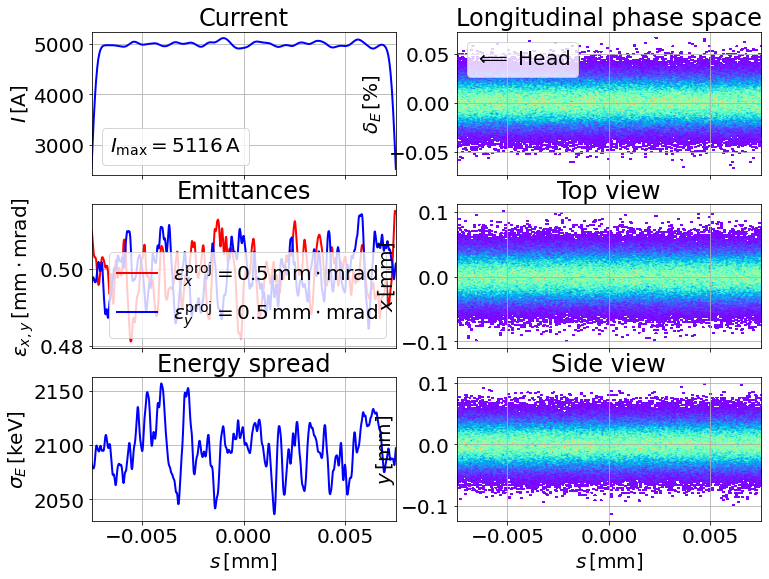

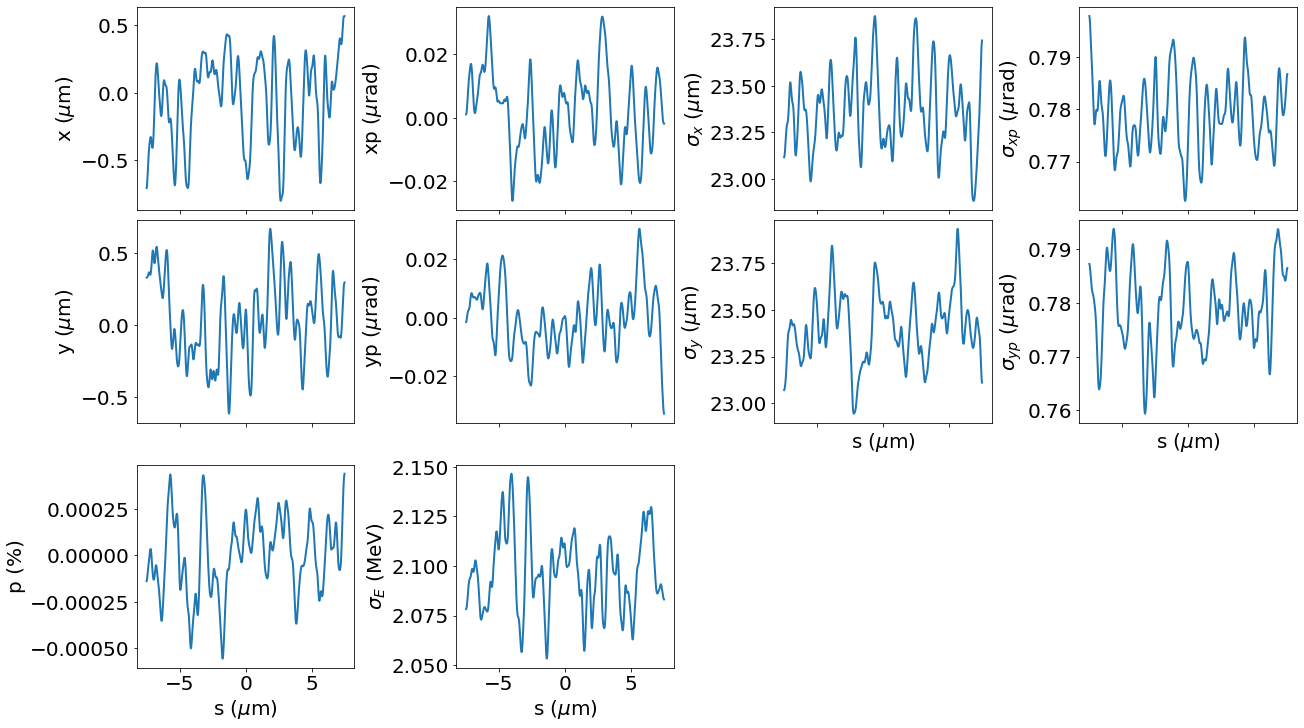

In [6]:
np.random.seed(10)
p_array_init = generate_parray(sigma_x=sigma_x, sigma_px=sigma_xp, sigma_y=sigma_x, sigma_py=sigma_xp, 
                         sigma_tau=7.5e-6, sigma_p=sigma_delta, chirp=0., charge=0.25e-09, 
                         nparticles=200000, energy=tws0.E, tau_trunc=None, shape='Flat')

show_e_beam(p_array_init, nparts_in_slice=4000, figsize=(12, 9))
plt.show()

plot_slices(p_array_init)


## Corrugated structure as dechirper
Here we use the numerical implementation of dechirper wakefield table. We set structure half gap to 0.5 mm and beam on axis (distance to plate 0.5mm). Here we only see the effect of longitudinal wake and transverse quadrupole wake.

tracking with Wakes .... 
z = 20.0 / 20.0. Applied: tracking with Wakes .... 
z = 20.0 / 20.0. Applied: ake

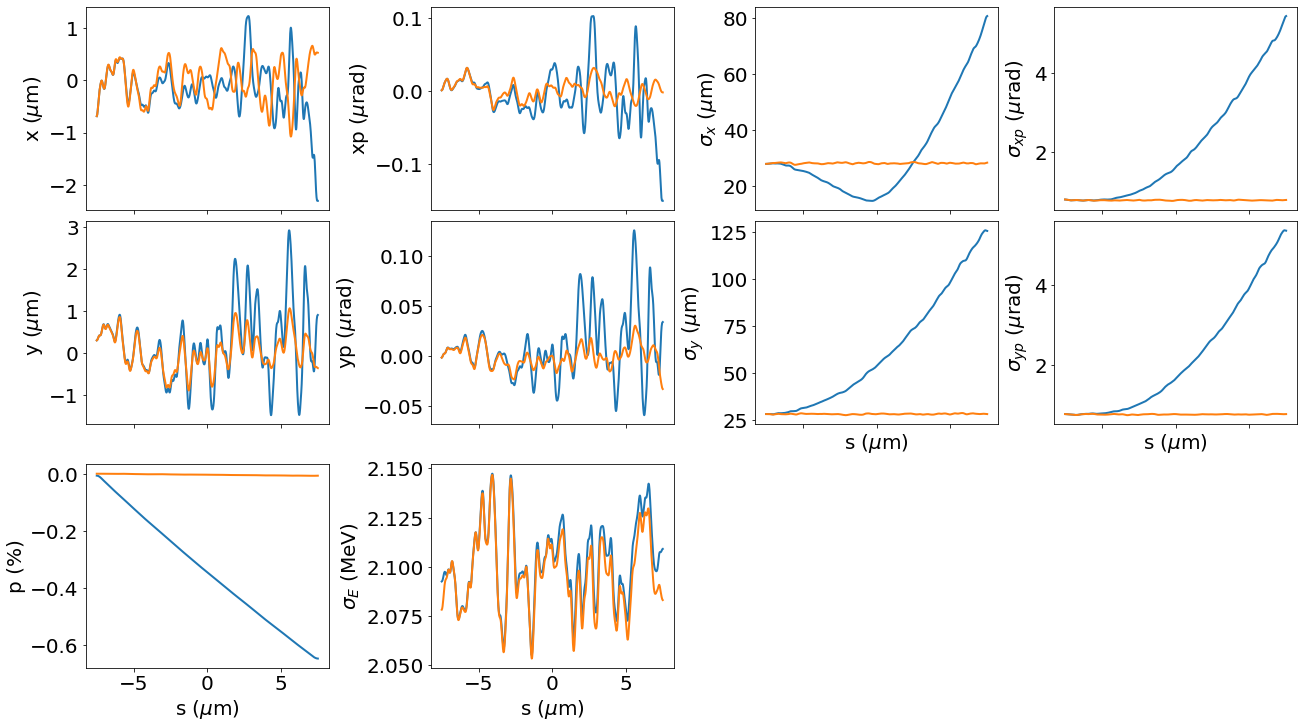

In [7]:
_, p1 = track_with_tilt_thin(p_array_init, 'N12', b=0.5e-3, a=0.5e-3)

_, p2 = track_with_tilt_thin(p_array_init, 'N12', b=5e-3, a=5e-3)

f, ax = plt.subplots(3, 4, sharex=True, figsize=(18,10), layout='constrained')
plot_slices(p1, ax=ax)
plot_slices(p2, ax=ax)

plt.show()

### Thick lens

tracking with Wakes .... 
z = 20.0 / 20.0. Applied: tracking with Wakes .... 
z = 20.0 / 20.0. Applied: ake

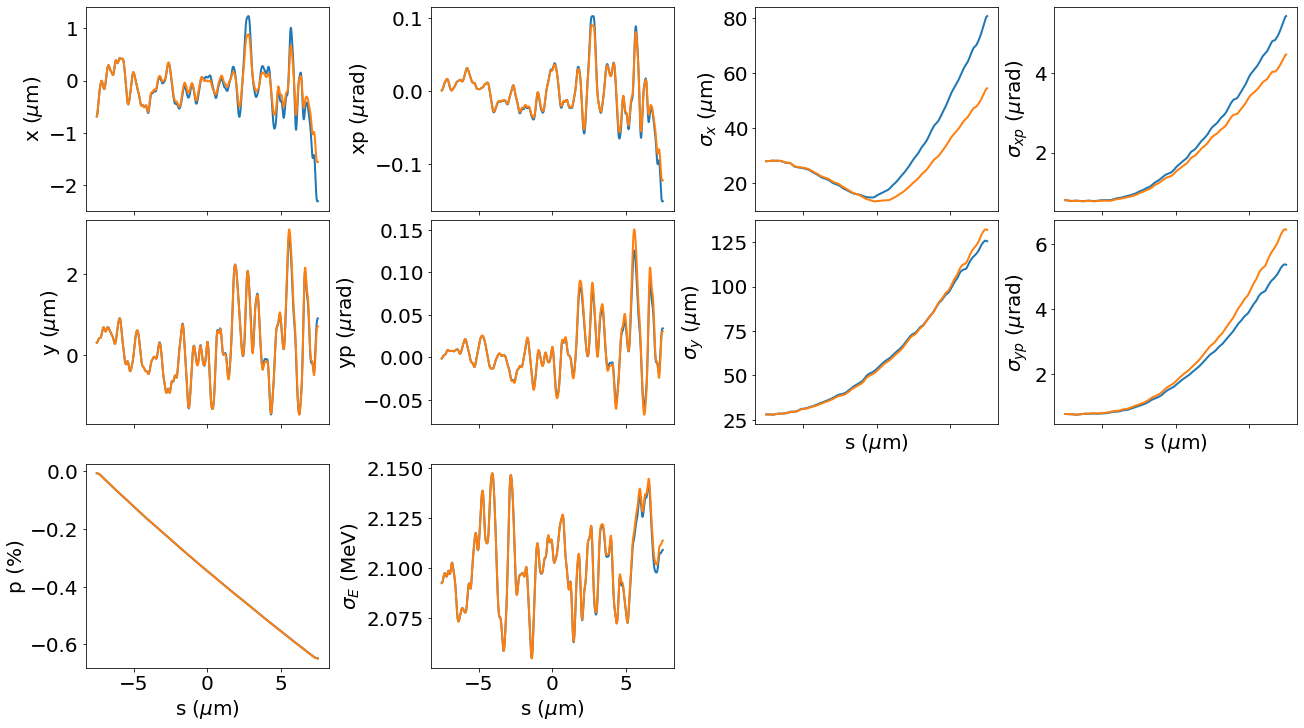

In [8]:
_, p1 = track_with_tilt_thin(p_array_init, 'N12', b=0.5e-3, a=0.5e-3)

_, p2 = track_with_tilt_thick(p_array_init, 'N12', b=0.5e-3, a=0.5e-3)

f, ax = plt.subplots(3, 4, sharex=True, figsize=(18,10), layout='constrained')
plot_slices(p1, ax=ax)
plot_slices(p2, ax=ax)

plt.show()

## Corrugated structure as a streaker
Here we use the numerical implementation of dechirper wakefield table. We set structure half gap to 10 mm and beam distance to plate 0.5mm. We can observe dechirping, streaking and focusing effect.

tracking with Wakes .... 
z = 20.0 / 20.0. Applied: tracking with Wakes .... 
z = 20.0 / 20.0. Applied: ake

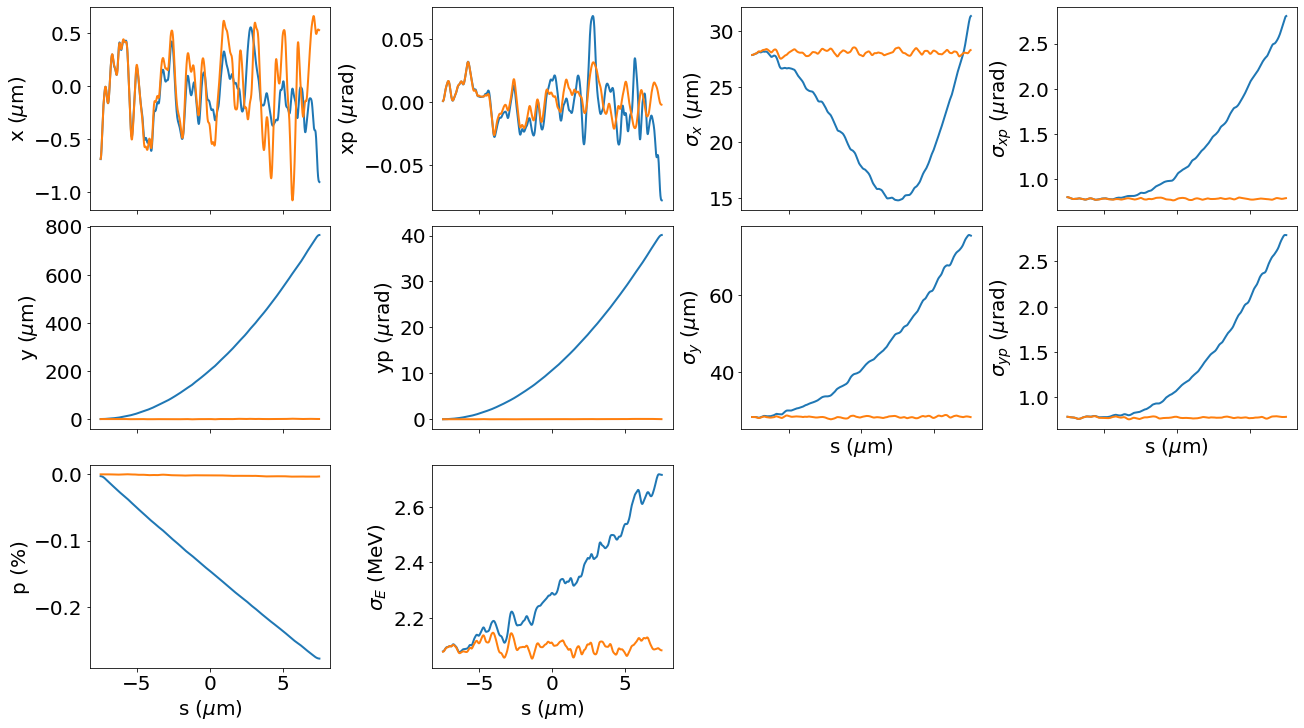

In [9]:
_, p1 = track_with_tilt_thin(p_array_init, 'N12', b=0.5e-3, a=10e-3)

_, p2 = track_with_tilt_thin(p_array_init, 'N12', b=5e-3, a=10e-3)

f, ax = plt.subplots(3, 4, sharex=True, figsize=(18,10), layout='constrained')
plot_slices(p1, ax=ax)
plot_slices(p2, ax=ax)

plt.show()

### Thick lens

tracking with Wakes .... 
z = 20.0 / 20.0. Applied: tracking with Wakes .... 
z = 20.0 / 20.0. Applied: ake

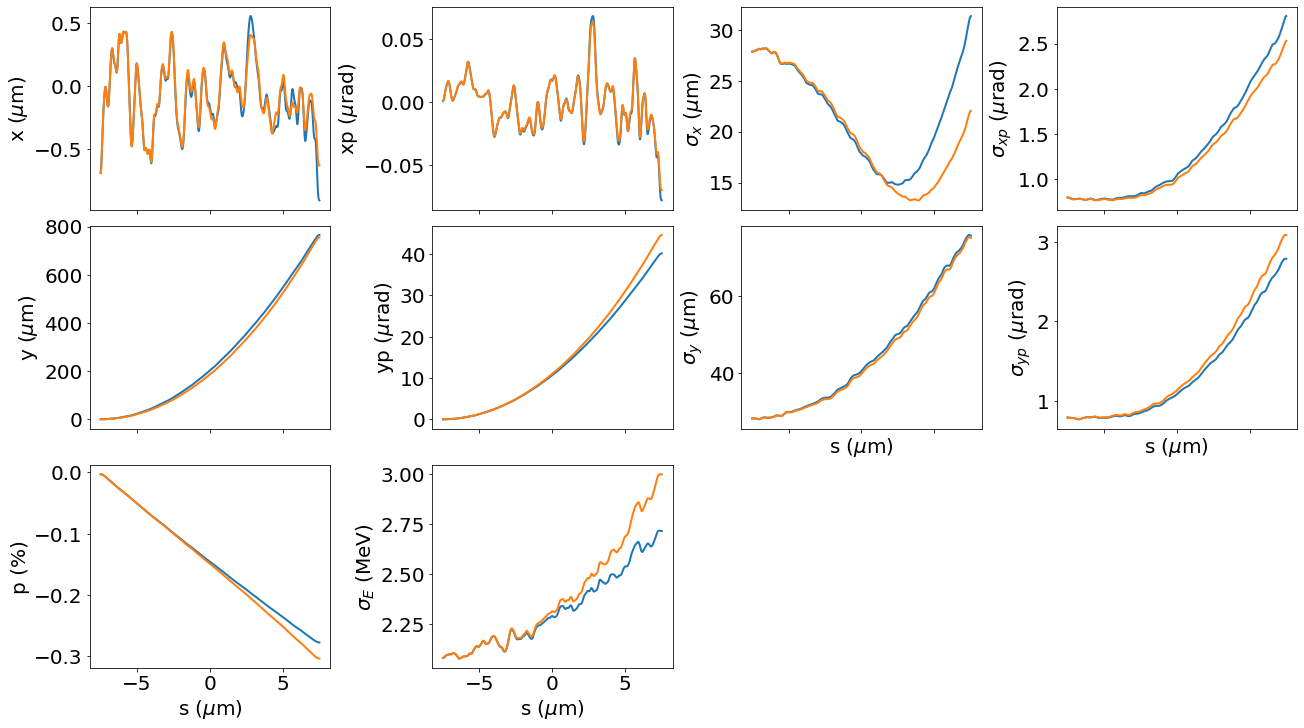

In [10]:
_, p1 = track_with_tilt_thin(p_array_init, 'N12', b=0.5e-3, a=10e-3)

_, p2 = track_with_tilt_thick(p_array_init, 'N12', b=0.5e-3, a=10e-3)

f, ax = plt.subplots(3, 4, sharex=True, figsize=(18,10), layout='constrained')
plot_slices(p1, ax=ax)
plot_slices(p2, ax=ax)

plt.show()

## Compare analytical model with numerical waketable
Here we compare out analytical implementation of the waketable with the numerical implementation.

tracking with Wakes .... 
z = 20.0 / 20.0. Applied: tracking with Wakes .... 
z = 20.0 / 20.0. Applied: ake

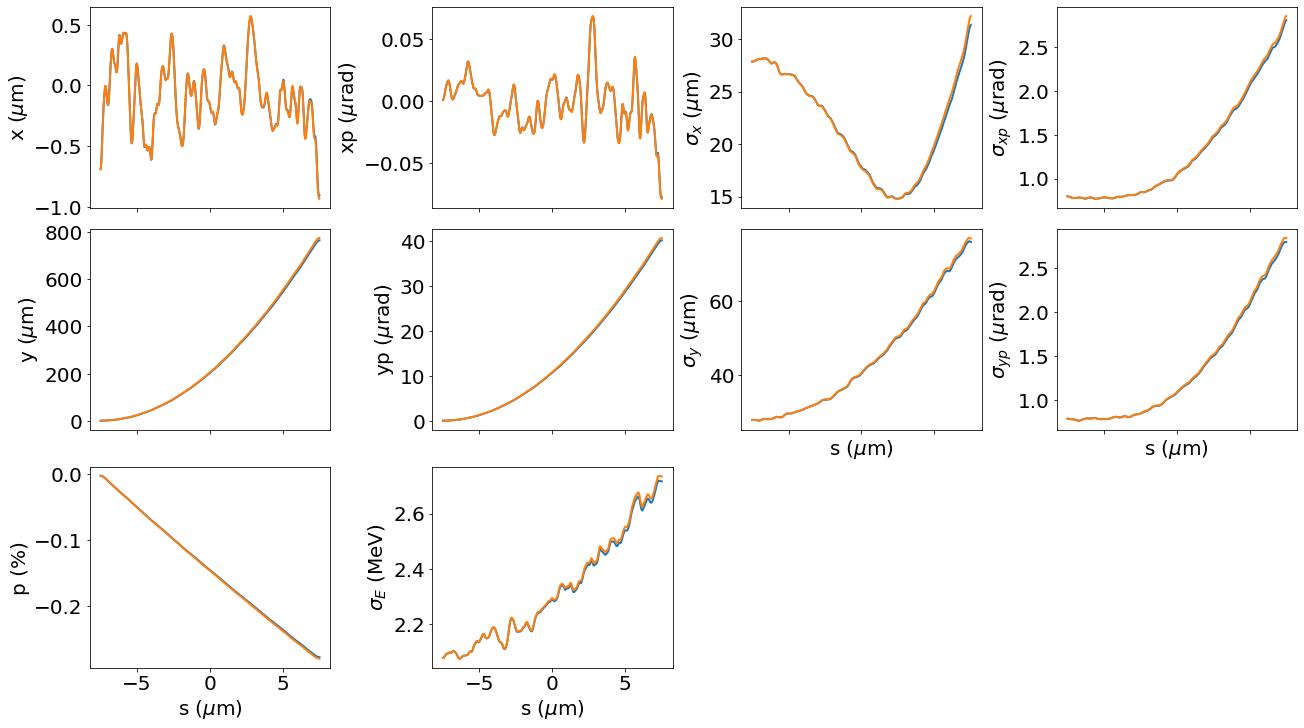

In [11]:
_, p1 = track_with_tilt_thin(p_array_init, 'N12', b=0.5e-3, a=10e-3)

_, p2 = track_with_tilt_thin(p_array_init, '12', b=0.5e-3, a=10e-3)

f, ax = plt.subplots(3, 4, sharex=True, figsize=(18,10), layout='constrained')
plot_slices(p1, ax=ax)
plot_slices(p2, ax=ax)

plt.show()

## Compare 2nd order Taylor expansion with 3rd order
It is necessary to check third order effect while the beam extension is rather large, here we assume a beam tilt in y, extending about 300um, and observe the third order effect mainly on the time-dependent focusing term, effect on the streaking and energy loss (spread) is small.

tracking with Wakes .... 
z = 20.0 / 20.0. Applied: tracking with Wakes .... 
z = 20.0 / 20.0. Applied: ake3

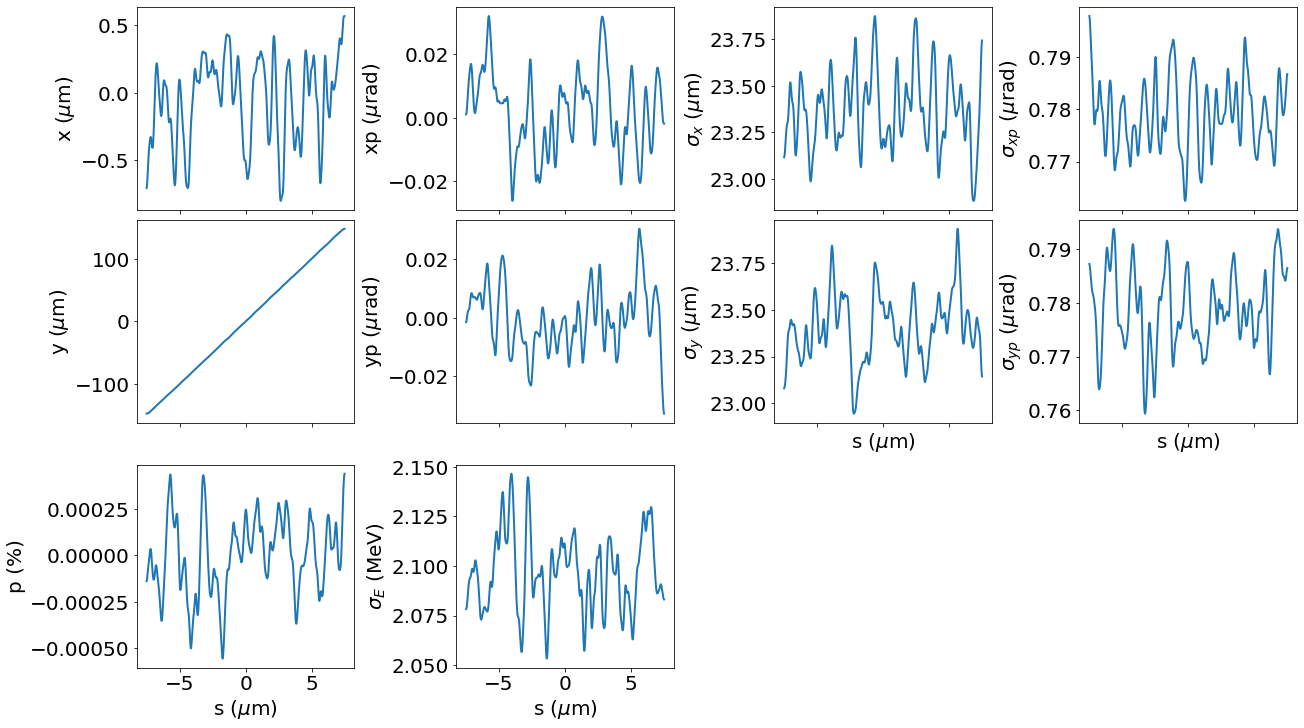

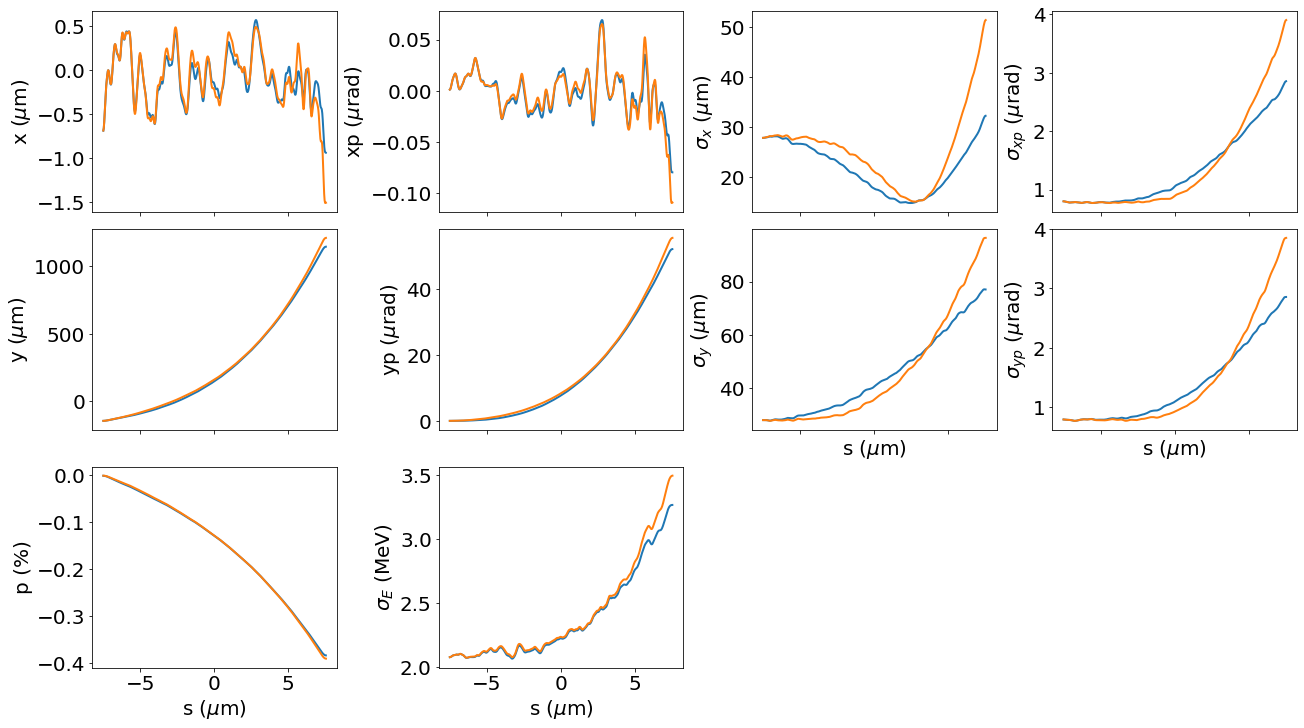

In [12]:
p0, p1 = track_with_tilt_thin(p_array_init, '12', b=0.5e-3, a=10e-3, tiltY=20)

_, p2 = track_with_tilt_thin(p_array_init, '13', b=0.5e-3, a=10e-3, tiltY=20)

f, ax = plt.subplots(3, 4, sharex=True, figsize=(18,10), layout='constrained')
plot_slices(p0, ax=ax)

f, ax = plt.subplots(3, 4, sharex=True, figsize=(18,10), layout='constrained')
plot_slices(p1, ax=ax)
plot_slices(p2, ax=ax)

plt.show()